In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from ast import literal_eval

In [14]:
movies = pd.read_csv('./data/movies.csv')
ratings = pd.read_csv('./data/ratings.csv')

In [15]:
user_item_matrix = ratings.pivot_table(index='user_id', columns='movie_id', values='rating_val')

user_item_matrix.fillna(0, inplace=True)

item_similarity = cosine_similarity(user_item_matrix.T)  # Transpose to get item-based similarity
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

In [16]:
def safe_literal_eval(x):
    try:
        return literal_eval(x)
    except (ValueError, SyntaxError):
        return []  

In [17]:
def create_soup(x):
    movie_title = str(x["movie_title"]) if pd.notna(x["movie_title"]) else ""
    genres = ' '.join(str(genre) for genre in x["genres"]) if isinstance(x["genres"], list) else ""
    overview = str(x["overview"]) if pd.notna(x["overview"]) else ""
    
    return " " + movie_title + " " + genres + " " + overview

movies["soup"] = movies.apply(create_soup, axis=1)
print(movies[["movie_title", "soup"]].head())

                                 movie_title  \
0                           The Adam Project   
1                Venom: Let There Be Carnage   
2                                 Red Notice   
3  Shang-Chi and the Legend of the Ten Rings   
4                                 Blacklight   

                                                soup  
0   The Adam Project  After accidentally crash-la...  
1   Venom: Let There Be Carnage  After finding a ...  
2   Red Notice  An Interpol-issued Red Notice is ...  
3   Shang-Chi and the Legend of the Ten Rings  Sh...  
4   Blacklight  Travis Block is a shadowy Governm...  


In [18]:
vectorizer = TfidfVectorizer(stop_words='english')
matrix = vectorizer.fit_transform(movies["soup"])

In [19]:
content_sim = cosine_similarity(matrix, matrix)

In [20]:
movie_ids_user_item = user_item_matrix.columns  # Movie IDs from the user-item matrix (user-item matrix columns)
movie_ids_movies = movies['movie_id'].values  # Movie IDs from the movies dataframe

# Ensure the order of movies matches between both similarity matrices
# Align the movie IDs in both matrices (content-based and collaborative)
content_sim_df = pd.DataFrame(content_sim, index=movie_ids_movies, columns=movie_ids_movies)
collab_sim_df = item_similarity_df.loc[movie_ids_user_item, movie_ids_user_item]  # Align the rows and columns with the movie IDs

# Convert the similarity matrices to numpy arrays
content_sim = np.array(content_sim_df)
collab_sim = np.array(collab_sim_df)

In [21]:
movie_titles_dict = dict(zip(movies['movie_id'], movies['movie_title']))

In [22]:
def predict_ratings(user_name, collab_sim, content_sim, user_item_matrix, movie_ids, top_n=10, alpha=0.5):
    user_ratings = user_item_matrix.loc[user_name]  # User's ratings
    rated_items = user_ratings[user_ratings > 0].index  # Items the user has rated
    predictions = {}

    # Map movie ID to its index in the similarity matrices
    movie_id_to_index = {movie_id: index for index, movie_id in enumerate(movie_ids)}

    for movie_id in movie_ids:  # Iterate over all movie IDs
        if movie_id not in rated_items:  # Only predict for unrated items
            # Get the index of the current movie_id
            movie_index = movie_id_to_index[movie_id]

            # Collaborative prediction (weighted by collaborative similarity)
            collab_sim_scores = collab_sim[movie_index, [movie_id_to_index[rated_item] for rated_item in rated_items]]
            collab_pred_rating = np.dot(collab_sim_scores, user_ratings[rated_items]) / np.sum(collab_sim_scores) if np.sum(collab_sim_scores) != 0 else 0

            # Content-based prediction (weighted by content similarity)
            content_sim_scores = content_sim[movie_index, [movie_id_to_index[rated_item] for rated_item in rated_items]]
            content_pred_rating = np.dot(content_sim_scores, user_ratings[rated_items]) / np.sum(content_sim_scores) if np.sum(content_sim_scores) != 0 else 0

            # Weighted average of collaborative and content-based predictions
            weighted_pred_rating = alpha * collab_pred_rating + (1 - alpha) * content_pred_rating

            predictions[movie_titles_dict[movie_id]] = weighted_pred_rating

    # Sort the predictions and return the top_n items
    top_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    return top_predictions

In [23]:
# Example: Get the top 10 recommendations for user 0 with alpha = 0.5 (equal weight)
user_name = "007filmreviwer"
recommendations = predict_ratings(user_name, collab_sim, content_sim,user_item_matrix,movie_ids_movies,top_n=10, alpha=0.9)

# Print the recommendations
print(f"Top 10 recommended movies for user {user_name}:")
for movie_id, predicted_rating in recommendations:
    print(f"{movie_id} ========= Predicted Rating: {predicted_rating:.2f}") 

Top 10 recommended movies for user 007filmreviwer:
Pinocchio ========= Predicted Rating: 6.00
The Predator ========= Predicted Rating: 6.00
Afterlife of the Party ========= Predicted Rating: 6.00
Texas Chainsaw 3D ========= Predicted Rating: 6.00
Justice League: The Flashpoint Paradox ========= Predicted Rating: 6.00
Iron Mask ========= Predicted Rating: 5.97
Vampire Hunter D: Bloodlust ========= Predicted Rating: 5.96
Mighty Morphin Power Rangers: The Movie ========= Predicted Rating: 5.94
Allied ========= Predicted Rating: 5.94
Mazinger Z: Infinity ========= Predicted Rating: 5.92


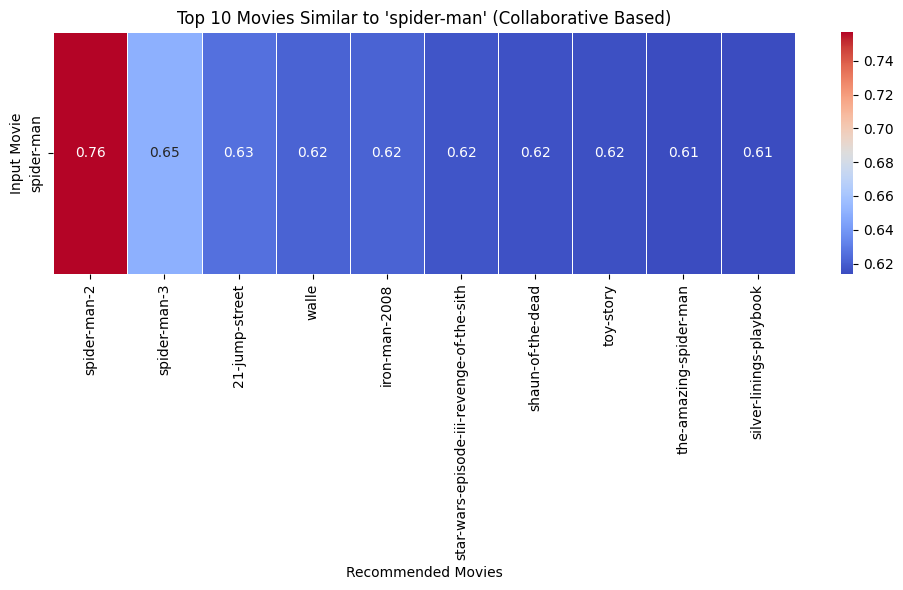

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


similarity_matrix = 0.9*collab_sim + content_sim*0.1
similarity_matrix = pd.DataFrame(similarity_matrix, index=user_item_matrix.columns, columns=user_item_matrix.columns)
 
 
def recommend_movies_for_single(input_movie, similarity_matrix, top_n=10):
    if input_movie not in similarity_matrix.index:
        return []
     
    similarity_scores = similarity_matrix.loc[input_movie]
 
    similar_movies = similarity_scores.nlargest(top_n + 1).iloc[1:]  # Exclude the input movie
    return similar_movies
 
input_movie = "spider-man"
 
similar_movies = recommend_movies_for_single(input_movie, similarity_matrix)
 
heatmap_data = pd.DataFrame(similar_movies).T
heatmap_data.index = [input_movie]
 
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data,annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f"Top 10 Movies Similar to '{input_movie}' (Collaborative Based)")
plt.xlabel("Recommended Movies")
plt.ylabel("Input Movie")
plt.tight_layout()
plt.show()